## Polynomial Regression Examples and Applications

With thanks to Oliver W. Layton

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp_la

## Load in Boston Housing data

CSV filename: `boston.csv`

In [11]:
data = np.array(np.genfromtxt('data/boston.csv', delimiter=',', skip_header=2, dtype=float, encoding='utf-8'))  
#bostonData = data.Data('data/boston.csv')
print(data)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 4.9800e+00 2.4000e+01]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 9.1400e+00 2.1600e+01]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 4.0300e+00 3.4700e+01]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 5.6400e+00 2.3900e+01]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 6.4800e+00 2.2000e+01]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 7.8800e+00 1.1900e+01]]


Info on the headers:

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per 10,000 dollars
    PTRATIO - pupil-teacher ratio by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in 1000's dollars
    

In [12]:
split = np.array_split(data, 10)
train = np.vstack((split[0], split[1], split[7], split[3], split[4], split[5], split[6], split[8], split[9]))
test = split[2]

Generally you want to split into:
* Train
* Dev which you use to try different models, modeling approaches, combinations of features etc
* Test and then hide test away and do not look at it

If your data is big enough then you want an 80/10/10 split.

If you are doing *real science* then you split your data 10fold, and every experiment is done 10 times, and then you can calculate confidence intervals. This is call (10)-fold cross validation.

The better way to do cross validation is to do a random 80/10/10 split, train, dev, and then do that again 9 more times.

No matter what, when do a split, pay attention:
* if the data is time-ordered, split by time
* if not, look at the values of the dependent variable and make sure they are represented in all splits

## 1. Perform linear regression to predict median home value from distance to workplace hubs

Independent and dependent variables? 'dis' and 'medv'

In [13]:
def getSummaryStatistics(data):
    return np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0, dtype=int)])

def getShapeType(data):
    return (data.shape, data.dtype)

def plotxyyhat(x, y, m, b):
    plt.plot(x, y, 'o', label='data')
    yhat = m*x + b
    plt.plot(x, yhat, label='least squares fit, $y = mx + b$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()
    
def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    # This is the dependent variable 
    y = data[:, dependent]
    print(getSummaryStatistics(y))
    print(getShapeType(y))

    # This is the regression coefficients that were fit, plus some other results
    c, res, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    return np.dot(A, c)

# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

In [14]:
c = fit(train, [7], 12)
yhat = predict(test, [7], c)
rsquared(test[:, 12], yhat)

[[12.1265]
 [ 1.1296]
 [ 3.    ]]
((455, 1), dtype('float64'))
[[ 1.     12.1265]
 [ 1.      1.1296]
 [ 1.      3.    ]]
((455, 2), dtype('float64'))
[50.  5. 22.]
((455,), dtype('float64'))
[[2.7778]
 [1.3216]
 [1.    ]]
((51, 1), dtype('float64'))
[[1.     2.7778]
 [1.     1.3216]
 [1.     1.    ]]
((51, 2), dtype('float64'))


-1.1815752525442003

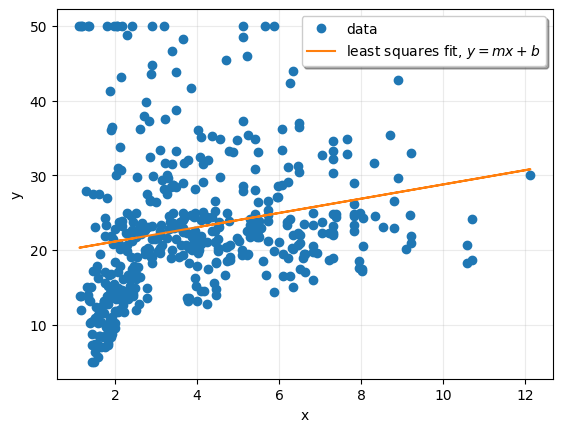

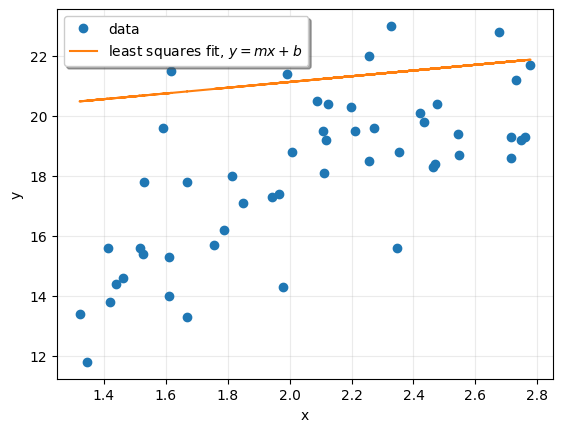

In [15]:
plotxyyhat(train[:, 7], train[:, 12], c[1], c[0])
plotxyyhat(test[:, 7], test[:, 12], c[1], c[0])

## 2. Use polynomial regression to better fit the nonlinear data relationship

### Try Quadratic polynomial model:

$$y = c_0 + c_1x_1 + c_2x_1^2$$

where $x_1$ is what?

In [16]:
def makePoly(x, poly):
    A = np.zeros([x.shape[0], poly+1])
    for i in range(0, poly+1):
        A[:, i] = np.squeeze(x**i)
    print(getSummaryStatistics(A))
    print(getShapeType(A))
    return A
    
def fit(data, independent, dependent, poly):
    # This is our independent variable, just one for now
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = makePoly(x, poly)
    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    # c, res, _, _ = sp.linalg.lstsq(A, y)
    c, res, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, poly, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = makePoly(x, poly)

    return np.dot(A, c)

In [17]:
c = fit(train, [7], 12, 2)
yhat = predict(test, [7], 2, c)
rsquared(test[:, 12], yhat)

[[  1.          12.1265     147.05200225]
 [  1.           1.1296       1.27599616]
 [  1.           3.          19.        ]]
((455, 3), dtype('float64'))
[[1.         2.7778     7.71617284]
 [1.         1.3216     1.74662656]
 [1.         1.         3.        ]]
((51, 3), dtype('float64'))


-0.2982192981534373

In [18]:
def plotxyyhat(x, y, c):
    plt.clf()
    plt.plot(x, y, 'o', label='data')
    xCurve = np.linspace(np.min(x), np.max(x))
    yCurve = c[0]
    for i in range(1, len(c)):
        yCurve += c[i]*(xCurve**i)
    plt.plot(xCurve, yCurve, label='least squares fit, y polynomial')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

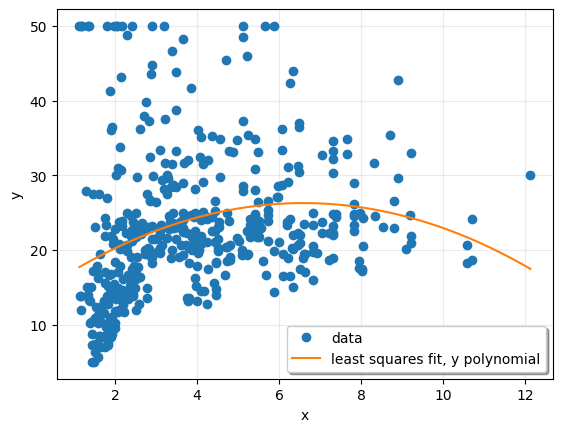

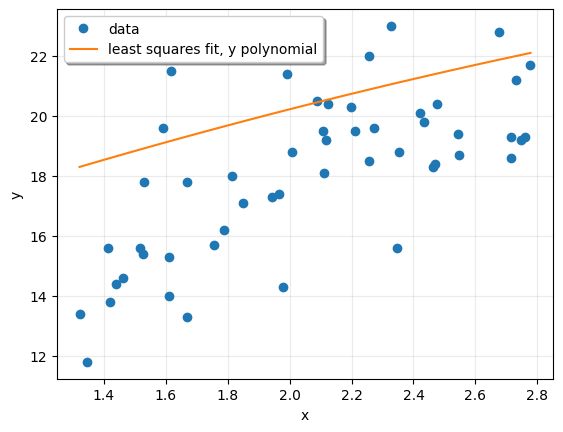

In [19]:
plotxyyhat(train[:, 7], train[:, 12], c)
plotxyyhat(test[:, 7], test[:, 12], c)

### Now let's try a cubic model

$$y = c_0 + c_1x_1 + c_2x_1^2 + c_3x_1^3$$

In [20]:
c = fit(train, [7], 12, 10)
yhat = predict(test, [7], 10, c)
rsquared(test[:, 12], yhat)

[[1.00000000e+00 1.21265000e+01 1.47052002e+02 1.78322611e+03
  2.16242914e+04 2.62226969e+05 3.17989534e+06 3.85610009e+07
  4.67609977e+08 5.67047239e+09 6.87629834e+10]
 [1.00000000e+00 1.12960000e+00 1.27599616e+00 1.44136526e+00
  1.62816620e+00 1.83917654e+00 2.07753382e+00 2.34678220e+00
  2.65092518e+00 2.99448508e+00 3.38257034e+00]
 [1.00000000e+00 3.00000000e+00 1.90000000e+01 1.25000000e+02
  8.86000000e+02 6.87200000e+03 5.73560000e+04 5.08684000e+05
  4.74571000e+06 4.61908000e+07 4.65763826e+08]]
((455, 11), dtype('float64'))
[[1.00000000e+00 2.77780000e+00 7.71617284e+00 2.14339849e+01
  5.95393233e+01 1.65388332e+02 4.59415709e+02 1.27616496e+03
  3.54493102e+03 9.84710938e+03 2.73533004e+04]
 [1.00000000e+00 1.32160000e+00 1.74662656e+00 2.30834166e+00
  3.05070434e+00 4.03181086e+00 5.32844123e+00 7.04206793e+00
  9.30679697e+00 1.22998629e+01 1.62554988e+01]
 [1.00000000e+00 1.00000000e+00 3.00000000e+00 9.00000000e+00
  2.20000000e+01 5.40000000e+01 1.31000000e+02 

-1.0911840081687614

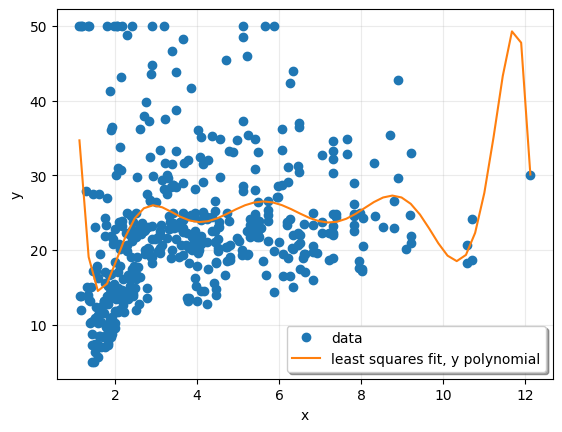

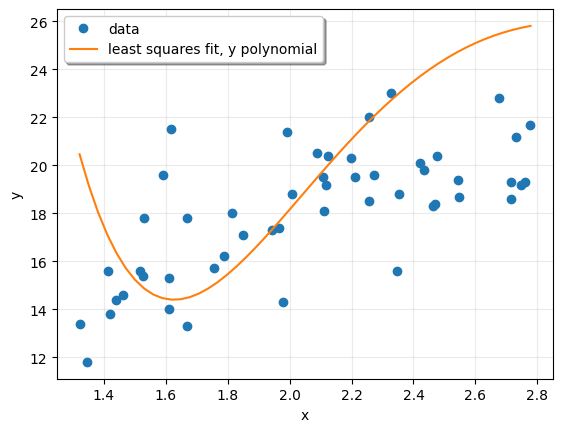

In [21]:
plotxyyhat(train[:, 7], train[:, 12], c)
plotxyyhat(test[:, 7], test[:, 12], c)